**Please don't edit this cell!**

# Marks and Feedback

**Total Marks:**   XX/100

**Overall comments:**


## Part 1. Investigations into Neural Networks (35 marks)

* **Task 1**:   *Experiments with learning rate schedules* - XX/5
    * learning rate schedulers implemented
    * experiments carried out
    * further comments


* **Task 2**:   *Experiments with regularisation* - XX/5
    * L1 experiments
    * L2 experiments
    * dropout experiments
    * annealed dropout implmented
    * further experiments carried out
    * further comments
    

* **Task 3**:   *Experiments with pretraining* - XX/15
    * autoencoder pretraining implemented
    * denoising autoencoder pretraining implemented
    * CE layer-by-layer pretraining implemented
    * experiments
    * further comments


* **Task 4**:   *Experiments with data augmentation* - XX/5
    * training data augmneted using noise, rotation, ...
    * any further augmnetations
    * experiments 
    * further comments


* **Task 5**:   *State of the art* - XX/5
    * motivation for systems constructed
    * experiments
    * accuracy of best system
    * further comments



## Part 2. Convolutional Neural Networks (55 marks)

* **Task 6**:   *Implement convolutional layer* - XX/20
    * linear conv layer
    * sigmoid conv layer
    * relu conv layer
    * any checks for correctness
    * loop-based or vectorised implementations
    * timing comparisons


* **Task 7**:   *Implement maxpooling layer* - XX/10
    * implementation of non-overlapping pooling
    * generic implementation
    * any checks for correctness


* **Task 8**:   *Experiments with convolutional networks* - XX/25
    * 1 conv layer (1 fmap)
    * 1 conv layer (5 fmaps)
    * 2 conv layers
    * further experiments



## Presentation (10 marks)

* ** Marks:**   XX/10
    * Concise description of each system constructed
    * Experiment design and motivations for different systems
    * Presentation of results - graphs, tables, diagrams
    * Conclusions



# Coursework #2

## Introduction


## Previous Tutorials

Before starting this coursework make sure that you have completed the following labs:

* [04_Regularisation.ipynb](https://github.com/CSTR-Edinburgh/mlpractical/blob/master/04_Regularisation.ipynb) - regularising the model
* [05_Transfer_functions.ipynb](https://github.com/CSTR-Edinburgh/mlpractical/blob/master/05_Transfer_functions.ipynb) - building and training different activation functions
* [06_MLP_Coursework2_Introduction.ipynb](https://github.com/CSTR-Edinburgh/mlpractical/blob/master/06_MLP_Coursework2_Introduction.ipynb) - Notes on numpy and tensors


## Submission
**Submission Deadline:  Thursday 14 January 2016, 16:00** 

Submit the coursework as an ipython notebook file, using the `submit` command in the terminal on a DICE machine. If your file is `06_MLP_Coursework1.ipynb` then you would enter:

`submit mlp 2 06_MLP_Coursework1.ipynb` 

where `mlp 2` indicates this is the second coursework of MLP.

After submitting, you should receive an email of acknowledgment from the system confirming that your submission has been received successfully. Keep the email as evidence of your coursework submission.

**Please make sure you submit a single `ipynb` file (and nothing else)!**

**Submission Deadline:  Thursday 14 January 2016, 16:00** 



## Getting Started
Please enter your student number and the date in the next code cell.

In [ ]:
#MLP Coursework 2
#Student number: <ENTER STUDENT NUMBER>
#Date: <ENTER DATE>

In [30]:
import numpy

#Seed a random number generator running the below cell, but do **not** modify the seed.
rng = numpy.random.RandomState([2015,10,10])
rng_state = rng.get_state()

import logging
import time
import matplotlib.pyplot as plt

from mlp.costs import MSECost, CECost  # import the cost we want to use for optimisation
from mlp.dataset import MNISTDataProvider  # import data provider
from mlp.layers import MLP, Sigmoid, Softmax, Linear  # import required layer types
from mlp.optimisers import SGDOptimiser, AutoEncoder, CrossEntropy  # import the optimiser
from mlp.schedulers import LearningRateFixed, LearningRateNewBob, DropoutFixed, DropoutAnnealing, LearningRateExp, LearningRateRecip
from mlp.noise import NoiseMaker, DropoutNoise
from mlp.dataset import add_batches
from mlp.conv import ConvLinear, ConvSigmoid, ConvRelu, ConvMaxPool2D

logger = logging.getLogger()
logger.warning('Initialising data providers...')
train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=-10, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=100, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=100, max_num_batches=-10, randomize=False)

class Result(object):
    """ A convenience object for recording results of a model """
    def __init__(self, title):
        self.title = title
        self.train_errors_matrix = []
        self.valid_errors_matrix = []
        self.test_errors = []
        
    def add_train(self, train_stats):
        train_errors = [10.0 * (1-train_stat[1]) for train_stat in train_stats]
        self.train_errors_matrix.append(train_errors)
        
    def add_valid(self, valid_stats):
        valid_errors = [10.0 * (1-valid_stat[1]) for valid_stat in valid_stats]
        self.valid_errors_matrix.append(valid_errors)
        
    def add_test(self, tst_accuracy):
        self.test_errors.append(1-tst_accuracy)
        
    def add_results(self, train_stats, valid_stats, tst_accuracy):
        self.add_train(train_stats)
        self.add_valid(valid_stats)
        self.add_test(tst_accuracy)
        
    def draw(self, iteration_name, rows, cols, figsize, train_y_lim=None, valid_y_lim=None):
        fig, axis_array = plt.subplots(rows, cols, figsize=figsize)

        for i, train_errors in enumerate(self.train_errors_matrix):
            axis_array[0].plot(train_errors, label='{0} {1} ({2} epochs)'.format(
                    iteration_name, str(i), len(train_errors)))

        for i, valid_errors in enumerate(self.valid_errors_matrix):
            axis_array[1].plot(valid_errors, label='{0} {1} ({2} epochs)'.format(
                    iteration_name, str(i), len(valid_errors)))

        # show to line graphs using the training and validation results
        axis_array[0].set_title("T - {0}".format(self.title))
        axis_array[0].set_xlabel('epoch')
        axis_array[0].set_ylabel('training error')  
        axis_array[0].legend()
        axis_array[0].grid()
        if train_y_lim:
            axis_array[0].set_ylim(0, train_y_lim)

        axis_array[1].set_title("V - {0}".format(self.title))
        axis_array[1].set_xlabel('epoch')
        axis_array[1].set_ylabel('validation error')
        axis_array[1].legend()
        axis_array[1].grid()
        if valid_y_lim:
            axis_array[1].set_ylim(0, valid_y_lim)
            
        plt.show()
        
def reset_data():
    train_dp.reset()
    valid_dp.reset()
    test_dp.reset()

# Part 1. Investigations into Neural Networks (35 marks)

In this part you are may choose exactly what you implement. However, you are expected to express your motivations, observations, and findings in a clear and cohesive way. Try to make it clear why you decided to do certain things. Use graphs and/or tables of results to show trends and other characteristics you think are important. 

For example, in Task 1 you could experiment with different schedulers in order to compare their convergence properties. In Task 2 you could look into (and visualise) what happens to weights when applying L1 and/or L2 regularisation when training. For instance, you could create sorted histograms of weight magnitudes in in each layer, etc..

**Before submission, please collapse all the log entries into smaller boxes (by clicking on the bar on the left hand side)**

### Task 1 - Experiments with learning rate schedules (5 marks)

Investigate the effect of learning rate schedules on training and accuracy.  Implement at least one additional learning rate scheduler mentioned in the lectures. 

#### EXPERIMENT
For this experiment I decided to compare the effect of the value of r on the exponential and reciprocal learning rate shedulers. To do this, I put them side by side with the fixed and new bob learing rate shedulers.

In [5]:
#load the corresponding code here, and also attach scripts that run the experiments ()
%matplotlib inline

logger = logging.getLogger()
logger.setLevel(logging.WARNING)

# some hyper-parameters
nhid = 100
max_epochs = 10
cost = CECost()
num_layers = 1
rate_list = [1.0, 5.0, 10.0, 20.0]

results_set = []

for rate in rate_list:
    # make a list of the Schedulers
    s1 = LearningRateFixed(learning_rate=0.1, max_epochs=max_epochs), "Fixed"
    s2 = LearningRateNewBob(start_rate=0.1, max_epochs=max_epochs), "NewBob"
    s3 = LearningRateExp(learning_rate=2.0, max_epochs=max_epochs, rate=rate), "Exponential"
    s4 = LearningRateRecip(learning_rate=2.0, max_epochs=max_epochs, rate=rate, c=1.0), "Reciprocal"
    schedulers = [s1, s2, s3, s4]
    
    results = Result("Schedulers rate {0}".format(rate)) 
    for scheduler, title in schedulers:
        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        # define the model structure
        model = MLP(cost=cost)
        model.add_layer(Sigmoid(idim=784, odim=nhid, irange=0.2, rng=rng))
        for i in xrange(1, num_layers):
            logger.info("Stacking hidden layer (%s)" % str(i+1))
            model.add_layer(Sigmoid(idim=nhid, odim=nhid, irange=0.2, rng=rng))
        model.add_layer(Softmax(idim=nhid, odim=10, rng=rng))

        # define the optimiser, here stochasitc gradient descent
        optimiser = SGDOptimiser(lr_scheduler=scheduler)

        logger.info('Training started...')
        train_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set...')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.warning('MNIST test set accuracy is %.2f %% (cost is %.3f)' % (tst_accuracy * 100., tst_cost))

        results.add_results(train_stats, valid_stats, tst_accuracy)
    results_set.append(results)

#### RESULTS
The results on the graph show the classification accuracy on the test set per epoch up to 10 epochs.
We can see that exponential and reciprocal converge faster since the learing rate for the first few epoch is higher.
We can also expect to achive a higher classification accuracy by the end of the training sice the smaller learning rates allow the model to be more finely tuned.

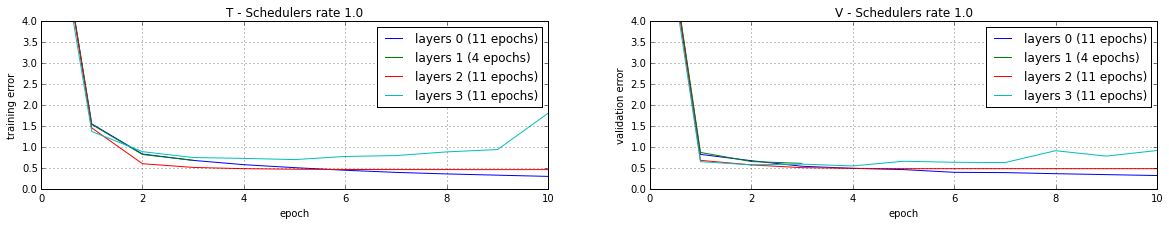

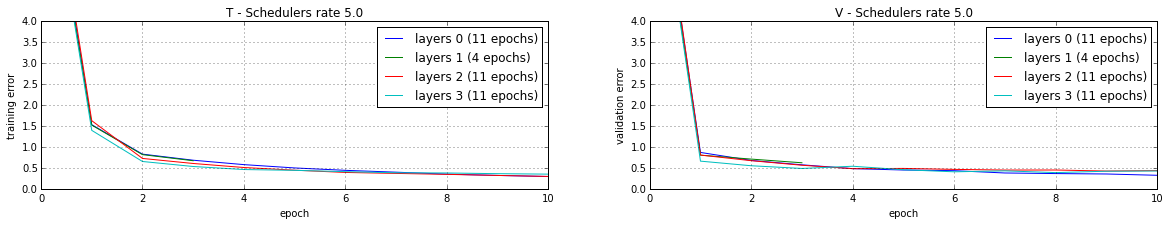

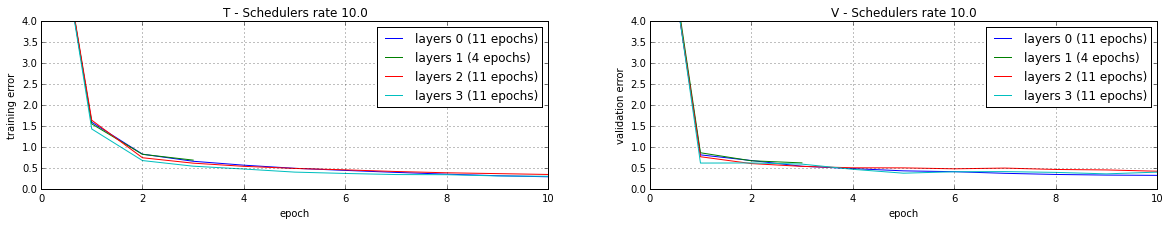

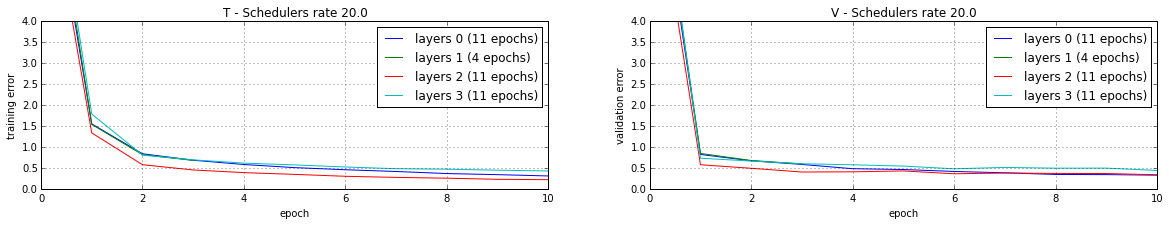

In [6]:
%matplotlib inline
for results in results_set:
    results.draw("layers", 1, 2, figsize=(20, 3), train_y_lim=4, valid_y_lim=4)

### Task 2 - Experiments with regularisers (5 marks)

Investigate the effect of different regularisation approaches (L1, L2, dropout).  Implement the annealing dropout scheduler (mentioned in lecture 5). Do some further investigations and experiments with model structures (and regularisers) of your choice. 

#### EXPERIMENT
This experiment tests the effect of L1 and L2 regularisation on the 
classification accuracy

I expect that dropout will basically add more training examples implicitly within the model
which could increase test accuracy (especially on small data sets) but might require more epochs to converge

In [32]:
%matplotlib inline

logger = logging.getLogger()
logger.setLevel(logging.WARNING)

# some hyper-parameters
nhid = 50
learning_rate = 0.5
max_epochs = 10
cost = CECost()
num_layers = 0

# make a list of the regularisers
l1_l2_weights = [
    (0.0, 0.0, "None"),
    (0.1, 0.0, "L1"),
    (0.0, 0.1, "L2"),
    (0.1, 0.1, "L1 and L2")
]

results = Result("L1 and L2 Regularisation")
weights = []

for l1_weight, l2_weight, title in l1_l2_weights:
    reset_data()
    # define the model structure
    model = MLP(cost=cost)
    model.add_layer(Sigmoid(idim=784, odim=nhid, irange=0.2, rng=rng))
    for i in xrange(1, num_layers):
        logger.info("Stacking hidden layer (%s)" % str(i+1))
        model.add_layer(Sigmoid(idim=nhid, odim=nhid, irange=0.2, rng=rng))
    model.add_layer(Softmax(idim=nhid, odim=10, rng=rng))

    # define the optimiser, here stochasitc gradient descent
    lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
    optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                             dp_scheduler=None,
                             l1_weight=l1_weight, 
                             l2_weight=l2_weight)

    logger.info('Training started...')
    train_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

    logger.info('Testing the model on test set...')
    tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
    logger.warning('MNIST test set accuracy is %.2f %% (cost is %.3f)' % (tst_accuracy * 100., tst_cost))

    weights.append((model.layers[0].W, model.layers[1].W))
    results.add_results(train_stats, valid_stats, tst_accuracy)

#### RESULTS
The l1 and l2 regulisation tends make the model prefer smaller weights.
We can see from the diagrams that 1l force all weights very close to 0, whereas l2 weights casue more of a bell shape of weights close to zero. The regularisation techniques will be useful in making sure that the model does not become overfit to the training set.

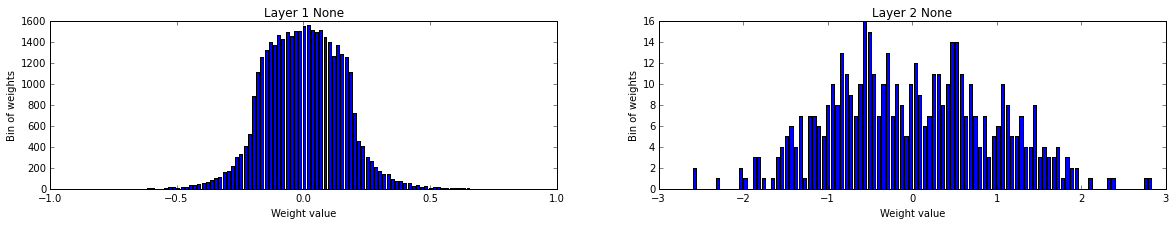

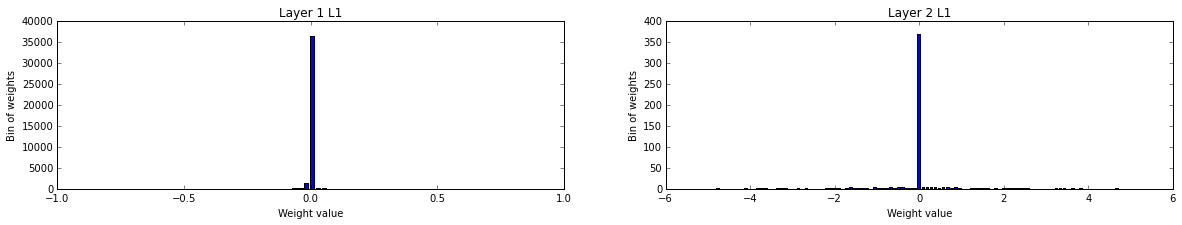

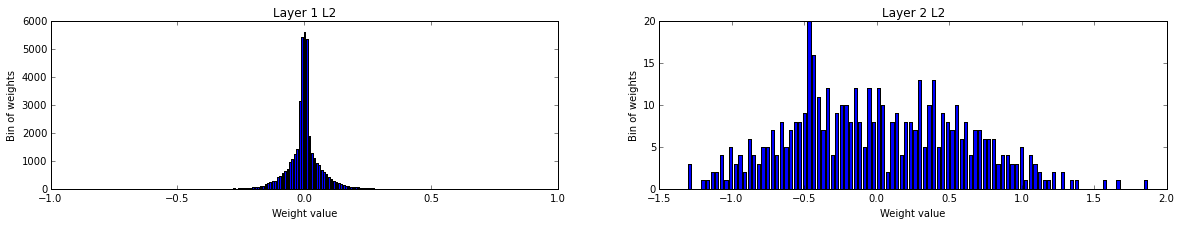

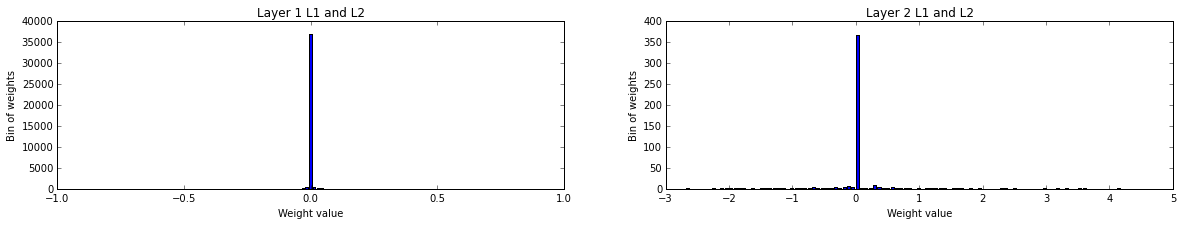

In [33]:
for i in xrange(len(weights)):
    fig, axis_array = plt.subplots(1, 2, figsize=(20, 3))

    w1, w2 = weights[i]
    _, _, title = l1_l2_weights[i]

    # show to line graphs using the training and validation results
    hist, bins = numpy.histogram(w1.T, bins=100)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    axis_array[0].bar(center, hist, align='center', width=width)
    axis_array[0].set_title("{0} {1}".format("Layer 1", title))
    axis_array[0].set_xlim(-1, 1)
    axis_array[0].set_xlabel('Weight value')
    axis_array[0].set_ylabel('Bin of weights')


    hist, bins = numpy.histogram(w2, bins=100)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    axis_array[1].bar(center, hist, align='center', width=width)
    axis_array[1].set_title("{0} {1}".format("Layer 2", title))
    axis_array[1].set_xlabel('Weight value')
    axis_array[1].set_ylabel('Bin of weights')

plt.show()

### EXPERIMENT
This experiment tests the effect of the dropout rate of dropout decay regulariser on the classification accuracy of the test set.



In [2]:
%matplotlib inline

logger = logging.getLogger()
logger.setLevel(logging.WARNING)

# some hyper-parameters
nhid = 50
learning_rate = 0.5
max_epochs = 10
cost = CECost()
num_layers = 0

# make a list of the regularisers
l1_l2_weights = [
    (0.0, 0.0, None, "None"),
#     (0.0001, 0.0, None, "L1"),
#     (0.0, 0.0001, None, "L2"),
    (0.0, 0.0, DropoutFixed(0.5, 0.5), "DropoutFixed"),
    (0.0, 0.0, DropoutAnnealing(0.5, 0.5, 0.03), "DropoutAnnealing rate 0.03"),
    (0.0, 0.0, DropoutAnnealing(0.5, 0.5, 0.05), "DropoutAnnealing rate 0.05"),
    (0.0, 0.0, DropoutAnnealing(0.5, 0.5, 0.07), "DropoutAnnealing rate 0.07"),
    (0.0, 0.0, DropoutAnnealing(0.5, 0.5, 0.09), "DropoutAnnealing rate 0.09"),
    (0.0, 0.0, DropoutAnnealing(0.5, 0.5, 0.11), "DropoutAnnealing rate 0.11"),
    (0.0, 0.0, DropoutAnnealing(0.5, 0.5, 0.13), "DropoutAnnealing rate 0.13"),
]


results = Result("Dropout Regularisation")
for l1_weight, l2_weight, dp_scheduler, title in l1_l2_weights:
    reset_data()
    # define the model structure
    model = MLP(cost=cost)
    model.add_layer(Sigmoid(idim=784, odim=nhid, irange=0.2, rng=rng))
    for i in xrange(1, num_layers):
        logger.info("Stacking hidden layer (%s)" % str(i+1))
        model.add_layer(Sigmoid(idim=nhid, odim=nhid, irange=0.2, rng=rng))
    model.add_layer(Softmax(idim=nhid, odim=10, rng=rng))

    # define the optimiser, here stochasitc gradient descent
    lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
    optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                             dp_scheduler=dp_scheduler,
                             l1_weight=l1_weight, 
                             l2_weight=l2_weight)

    logger.info('Training started...')
    train_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

    logger.info('Testing the model on test set...')
    tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
    logger.warning('MNIST test set accuracy is %.2f %% (cost is %.3f)' % (tst_accuracy * 100., tst_cost))

    results.add_results(train_stats, valid_stats, tst_accuracy)

In [ ]:


# RESULTS
# It seems the best classification accuracy comes from a dropout annealing 
# with these configurations
# DropoutAnnealing(0.5, 0.5, 0.05)
# Stoping decay after 10 epochs giving it just 1 epoch to fine tune

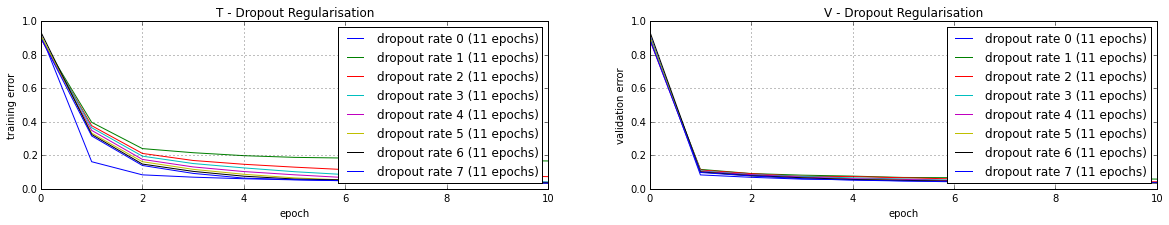

In [6]:
%matplotlib inline
results.draw("dropout rate", 1, 2, figsize=(20, 3))

### Task 3 - Experiments with pretraining (15 marks)

Implement pretraining of multi-layer networks with autoencoders, denoising autoencoders, and using  layer-by-layer cross-entropy training.  

Implementation tip: You could add the corresponding methods to `optimiser`, namely, `pretrain()` and `pretrain_epoch()`, for autoencoders. Simiilarly, `pretrain_discriminative()` and `pretrain_epoch_discriminative()` for cross-entropy layer-by-layer pretraining. Of course, you can modify any other necessary pieces, but include all the modified fragments below.

In [4]:
def get_unit_count(layer_count, nhid_for_1_layer):
    """
    For a given layer count, calculates the number of units per layer
    such that the total number of weights remains the same
    b = layer_count
    (784 * x) + ((b-1)*(x**2)) + (x * 10) = 635200
    ((b-1)*(x**2)) + (794 * x) - 635200 = 0
    """
    if layer_count == 0:
        raise NotImplemented("Can calculate for 0 hidden layers")
    else :
        if layer_count == 1:
            return nhid_for_1_layer
        else:
            return (-794 + numpy.sqrt(794**2 - 4*(layer_count-1)*(-(nhid_for_1_layer*794)))) / (2 * (layer_count-1))

In [6]:
%matplotlib inline

logger = logging.getLogger()
logger.setLevel(logging.WARNING)

# some hyper-parameters
nhid_for_1_layer = 100
learning_rate = 0.5
max_epochs = 10
pre_max_epochs = 5
cost = CECost()
num_layers_list = [1, 2, 5, 10]

# make a list of the Pre Trainers
p0 = None, "None"
p1 = AutoEncoder(learning_rate=0.01, max_epochs=10), "AutoEncoder, lr=0.01"
p2 = AutoEncoder(learning_rate=0.05, max_epochs=10), "AutoEncoder, lr=0.05"
p3 = AutoEncoder(learning_rate=0.5, max_epochs=10), "AutoEncoder, lr=0.5"
p4 = AutoEncoder(learning_rate=1.0, max_epochs=10), "AutoEncoder, lr=1.0"
p5 = CrossEntropy(learning_rate=0.01, max_epochs=pre_max_epochs), "CrossEntropy, lr=0.01"
p6 = CrossEntropy(learning_rate=0.5, max_epochs=pre_max_epochs), "CrossEntropy, lr=0.5"
p7 = CrossEntropy(learning_rate=1.0, max_epochs=pre_max_epochs), "CrossEntropy, lr=1.0"
p8 = CrossEntropy(learning_rate=2.0, max_epochs=pre_max_epochs), "CrossEntropy, lr=2.0"
pre_trainers = [p0, p1, p2, p3, p4, p5, p6, p7, p8]

results_set = []

for pre_trainer, title in pre_trainers:
    results = Result(title)
    for num_layers in num_layers_list:
        # find the unit count such that the number of weights are the same as that of 1 hidden layer
        nhid = int(get_unit_count(num_layers, nhid_for_1_layer))
        logger.warning("Calculated hidden layer size of %s units" % str(int(nhid)))
        # define the model structure
        model = MLP(cost=cost)
        model.add_layer(Sigmoid(idim=784, odim=nhid, irange=0.2, rng=rng))
        for i in xrange(1, num_layers):
            logger.info("Stacking hidden layer (%s)" % str(i+1))
            model.add_layer(Sigmoid(idim=nhid, odim=nhid, irange=0.2, rng=rng))
        model.add_layer(Softmax(idim=nhid, odim=10, rng=rng))

        start = time.clock()
        reset_data()
        if pre_trainer:
            logger.info('Pre Training started...')
            pre_trainer.pretrain(model, train_iter=train_dp)
        reset_data()

        lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                                 dp_scheduler=None,
                                 l1_weight=0.0, 
                                 l2_weight=0.0)

        logger.info('Training started...')
        train_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)
        stop = time.clock()
        
        logger.info('Testing the model on test set...')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.warning('MNIST test set accuracy is %.2f %% (cost is %.3f) in %.0f seconds' 
                       % (tst_accuracy * 100., tst_cost, stop - start))

        results.add_results(train_stats, valid_stats, tst_accuracy)
    results_set.append(results)

In [ ]:
# Since AutoEncoder and CrossEntropy is designed to help train deep networks 
# I would predict that they should perform better on deeper neural nets

# EXPERIMENT
# the effect of:
#  - None vs AutoEncoder vs CrossEntropy
#  - pre training learning rate
#  - number of layers
# on the  classification accuracy.
# To make the test fair, each model will have the same number of trainable 
# weights despite the number of layers

# RESULTS
# 

In [ ]:
%matplotlib inline
for results in results_set:
    results.draw("layers", 1, 2, figsize=(20, 3))

### Task 4 - Experiments with data augmentation (5 marks)

Using the standard MNIST training data, generate some augmented training examples (for example, using noise or rotation). Perform experiments on using this expanded training data.

In [ ]:
%load mlp/noise.py

In [ ]:
%load -s add_batch,add_batches mlp/dataset.py

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


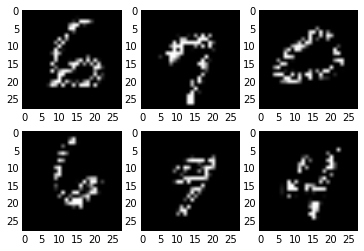

In [8]:
%pylab
%matplotlib inline

logger = logging.getLogger()
logger.warning('Initialising data providers...')
train_dp_aug = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=-10, randomize=True)
train_dp_aug.reset()

noise_type = DropoutNoise(dropout_prob=0.5)
noise_maker = NoiseMaker(data_set=train_dp_aug, num_batches=10, noise=noise_type)  
new_batches = noise_maker.make_examples(rng=rng)
add_batches(train_dp_aug, new_batches)

imgs_raw, digits = new_batches[0]

imgs = [img.reshape(28,28) for img in imgs_raw[:10]]

fig, ax = plt.subplots(2,3)
ax[0, 0].imshow(imgs[0], cmap=cm.Greys_r)
ax[0, 1].imshow(imgs[1], cmap=cm.Greys_r)
ax[0, 2].imshow(imgs[2], cmap=cm.Greys_r)
ax[1, 0].imshow(imgs[3], cmap=cm.Greys_r)
ax[1, 1].imshow(imgs[4], cmap=cm.Greys_r)
ax[1, 2].imshow(imgs[5], cmap=cm.Greys_r)

In [7]:
%matplotlib inline

logger = logging.getLogger()
logger.setLevel(logging.WARNING)


# some hyper-parameters
nhid = 50
learning_rate = 0.5
max_epochs = 10
cost = CECost()
num_layers = 0

dropout_probs_list = [0.9, 0.7, 0.5, 0.3]

results_list = []

for dropout_prob in dropout_probs_list:
    results = Result("Dropout Prob {}".format(dropout_prob))

    # make a list of the noise makers
    noise_makers = [
        NoiseMaker(data_set=train_dp, num_batches=1, noise=DropoutNoise(dropout_prob=dropout_prob)),
        NoiseMaker(data_set=train_dp, num_batches=10, noise=DropoutNoise(dropout_prob=dropout_prob)),
        NoiseMaker(data_set=train_dp, num_batches=100, noise=DropoutNoise(dropout_prob=dropout_prob)),
        NoiseMaker(data_set=train_dp, num_batches=500, noise=DropoutNoise(dropout_prob=dropout_prob)),
    ]

    for noise_maker in noise_makers:
        logger.info('Initialising data providers...')
        train_dp_aug = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=-10, randomize=True)

        logger.warning('Adding noisy examples...')
        new_batches = noise_maker.make_examples(rng=rng)
        add_batches(train_dp_aug, new_batches)
        reset_data()
        train_dp_aug.reset()

        # define the model structure
        model = MLP(cost=cost)
        model.add_layer(Sigmoid(idim=784, odim=nhid, irange=0.2, rng=rng))
        for i in xrange(1, num_layers):
            logger.info("Stacking hidden layer (%s)" % str(i+1))
            model.add_layer(Sigmoid(idim=nhid, odim=nhid, irange=0.2, rng=rng))
        model.add_layer(Softmax(idim=nhid, odim=10, rng=rng))

        # define the optimiser, here stochasitc gradient descent
        lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                                 dp_scheduler=None, l1_weight=0.0, l2_weight=0.0)

        logger.info('Training started...')
        train_stats, valid_stats = optimiser.train(model, train_dp_aug, valid_dp)

        logger.info('Testing the model on test set...')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.warning('MNIST test set accuracy is %.2f %% (cost is %.3f)' % (tst_accuracy * 100., tst_cost))

        results.add_results(train_stats, valid_stats, tst_accuracy)
    
    results_list.append(results)

In [ ]:
%matplotlib inline
for results in results_list:
    results.draw("Extra Data ", 1, 2, figsize=(20, 3))

### Task 5 - State of the art (5 marks)

Using any techniques you have learnt so far (combining any number of them), build and train the best model you can (no other constraints).

In [2]:
%matplotlib inline
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# some hyper-parameters
learning_rate = 2.0
max_epochs = 60
pre_max_epochs = 5
cost = CECost()

results = Result("State of the art")
train_dp_aug = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=-10, randomize=True)

logger.warning('Adding noisy examples...')
noise_maker = NoiseMaker(data_set=train_dp, num_batches=500, noise=DropoutNoise(dropout_prob=0.8))
new_batches = noise_maker.make_examples(rng=rng)
add_batches(train_dp_aug, new_batches)
train_dp_aug.reset()
    
# define the model structure
model = MLP(cost=cost)
model.add_layer(Sigmoid(idim=784, odim=311, irange=0.2, rng=rng))
model.add_layer(Sigmoid(idim=311, odim=311, irange=0.2, rng=rng))
model.add_layer(Sigmoid(idim=311, odim=311, irange=0.2, rng=rng))
model.add_layer(Sigmoid(idim=311, odim=311, irange=0.2, rng=rng))
model.add_layer(Sigmoid(idim=311, odim=311, irange=0.2, rng=rng))
model.add_layer(Sigmoid(idim=311, odim=311, irange=0.2, rng=rng))
model.add_layer(Softmax(idim=311, odim=10, rng=rng))

reset_data()
logger.info('Pre Training started...')
start = time.clock()

# pre = AutoEncoder(learning_rate=1.0, max_epochs=1)
pre = CrossEntropy(learning_rate=1.0, max_epochs=pre_max_epochs)
pre.pretrain(model, train_iter=train_dp_aug)
reset_data()

# lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
lr_scheduler = LearningRateExp(learning_rate=learning_rate, max_epochs=max_epochs, rate=16.0)
# lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs)
dp_scheduler = DropoutAnnealing(0.5, 0.5, 0.0125)
optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, dp_scheduler=None,
                         l1_weight=0.001, l2_weight=0.001)

logger.info('Training started...')
train_stats, valid_stats = optimiser.train(model, train_dp_aug, valid_dp)
stop = time.clock()

logger.info('Testing the model on test set...')
tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
logger.warning('MNIST test set accuracy is %.2f %% (cost is %.3f) in %.0f seconds' 
               % (tst_accuracy * 100., tst_cost, stop - start))

results.add_results(train_stats, valid_stats, tst_accuracy)

INFO:root:Pre Training started...
INFO:mlp.optimisers:Epoch 1: Pre-training cost (ce) is 0.488. Accuracy is 87.17%
INFO:mlp.optimisers:Epoch 2: Pre-training cost (ce) is 0.216. Accuracy is 93.64%
INFO:mlp.optimisers:Epoch 3: Pre-training cost (ce) is 0.161. Accuracy is 95.35%
INFO:mlp.optimisers:Epoch 4: Pre-training cost (ce) is 0.128. Accuracy is 96.25%
INFO:mlp.optimisers:Epoch 5: Pre-training cost (ce) is 0.108. Accuracy is 96.83%
INFO:mlp.optimisers:Epoch 1: Pre-training cost (ce) is 0.428. Accuracy is 91.66%
INFO:mlp.optimisers:Epoch 2: Pre-training cost (ce) is 0.116. Accuracy is 96.47%
INFO:mlp.optimisers:Epoch 3: Pre-training cost (ce) is 0.097. Accuracy is 97.05%
INFO:mlp.optimisers:Epoch 4: Pre-training cost (ce) is 0.089. Accuracy is 97.33%
INFO:mlp.optimisers:Epoch 5: Pre-training cost (ce) is 0.082. Accuracy is 97.47%
INFO:mlp.optimisers:Epoch 1: Pre-training cost (ce) is 0.342. Accuracy is 93.00%
INFO:mlp.optimisers:Epoch 2: Pre-training cost (ce) is 0.090. Accuracy is 9

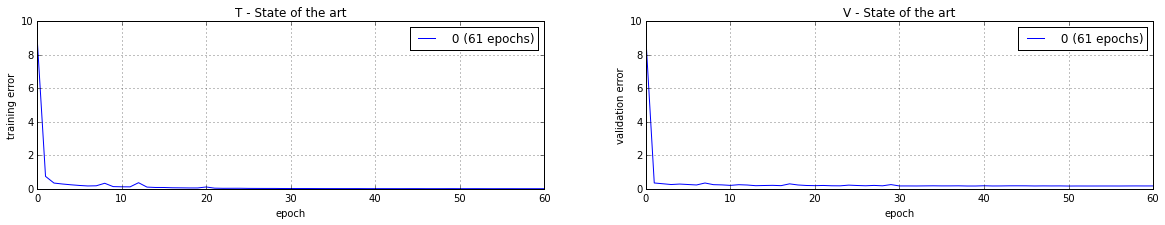

In [3]:
results.draw("", 1, 2, figsize=(20, 3))

# Part 2. Convolutional Neural Networks (55 marks)

In this part of the coursework, you are required to implement deep convolutional networks.  This includes code for forward prop, back prop, and weight updates for convolutional and max-pooling layers, and should support the stacking of convolutional + pooling layers.  You should implement all the parts relating to the convolutional layer in the mlp/conv.py module; if you decide to implement some routines in cython, keep them in mlp/conv.pyx). Attach both files in this notebook.

Implementation tips: Look at [lecture 7](http://www.inf.ed.ac.uk/teaching/courses/mlp/2015/mlp07-cnn.pdf) and [lecture 8](http://www.inf.ed.ac.uk/teaching/courses/mlp/2015/mlp08-cnn2.pdf), and the introductory tutorial, [06_MLP_Coursework2_Introduction.ipynb](https://github.com/CSTR-Edinburgh/mlpractical/blob/master/06_MLP_Coursework2_Introduction.ipynb)

### Task 6 -  Implement convolutional layer (20 marks)

Implement linear convolutional layer, and then extend to sigmoid and ReLU transfer functions (do it in a similar way to fully-connected layers). Include all relevant code.  It is recommended that you first implement in the naive way with nested loops (python and/or cython);  optionally you may then implement in a vectorised way in numpy.  Include logs for each way you implement the convolutional layer, as timings for different implementations are of interest.  Include all relevant code.

### Task 7 - Implement max-pooling layer (10 marks)

Implement a max-pooling layer. Non-overlapping pooling (which was assumed in the lecture presentation) is required. You may also implement a more generic solution with striding as well. Include all relevant code.

### Task 8 - Experiments with convolutional networks (25 marks)

Construct convolutional networks with a softmax output layer and a single fully connected hidden layer. Your first experiments should use one convolutional+pooling layer.  As a default use convolutional kernels of dimension 5x5 (stride 1) and pooling regions of 2x2 (stride 2, hence non-overlapping).

*  Implement and test a convolutional network with 1 feature map
*  Implement and test a convolutional network with 5 feature maps

Explore convolutional networks with two convolutional layers, by implementing, training, and evaluating a network with two convolutional+maxpooling layers with 5 feature maps in the first convolutional layer,  and 10 feature maps in the second convolutional layer.

Carry out further experiments to optimise the convolutional network architecture (you could explore kernel sizes and strides, number of feature maps, sizes and strides of pooling operator, etc. - it is up to you).

In [29]:
train_dp_conv = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=-10, randomize=True)
valid_dp_conv = MNISTDataProvider(dset='valid', batch_size=100, max_num_batches=-10, randomize=False)
test_dp_conv = MNISTDataProvider(dset='eval', batch_size=100, max_num_batches=-10, randomize=False)

In [3]:
%matplotlib inline

logger = logging.getLogger()
logger.setLevel(logging.INFO)

# some hyper-parameters
learning_rate = 0.5
max_epochs = 10
cost = CECost()
feature_maps_list = [1, 5]

results = Result("Covolution")

for feature_maps in feature_maps_list:
    # define the model structure
    model = MLP(cost=cost)
    model.add_layer(ConvSigmoid(1, feature_maps, image_shape=(28, 28), kernel_shape=(5, 5), stride=(1, 1), irange=0.2))
    model.add_layer(ConvMaxPool2D(num_feat_maps=feature_maps, conv_shape=(24, 24), pool_shape=(2, 2)))
    model.add_layer(Sigmoid(idim=144 * feature_maps, odim=100))
    model.add_layer(Softmax(idim=100, odim=10))

    lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
    optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                             dp_scheduler=None,
                             l1_weight=0.0, 
                             l2_weight=0.0)
    train_dp_conv.reset()
    valid_dp_conv.reset()
    test_dp_conv.reset()

    start = time.clock()
    logger.info('Training started...')
    train_stats, valid_stats = optimiser.train(model, train_dp_conv, valid_dp_conv)
    stop = time.clock()

    logger.info('Testing the model on test set...')
    tst_cost, tst_accuracy = optimiser.validate(model, test_dp_conv)
    logger.warning('MNIST test set accuracy is %.2f %% (cost is %.3f) in %.0f seconds' 
                   % (tst_accuracy * 100., tst_cost, stop - start))

    results.add_results(train_stats, valid_stats, tst_accuracy)

INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.368. Accuracy is 9.98%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.366. Accuracy is 9.61%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 1.141. Accuracy is 61.79%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.401. Accuracy is 88.64%
INFO:mlp.optimisers:Epoch 1: Took 42 seconds. Training speed 1316 pps. Validation speed 2517 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.396. Accuracy is 87.77%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.301. Accuracy is 90.94%
INFO:mlp.optimisers:Epoch 2: Took 43 seconds. Training speed 1329 pps. Validation speed 2045 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.328. Accuracy is 89.84%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.272. Accuracy is 91.70%
INFO:mlp.optimisers:Epoch 3: Took 42 seconds. Training speed 1318 pps. Validation speed 2498 pps.
INFO:mlp.optimiser

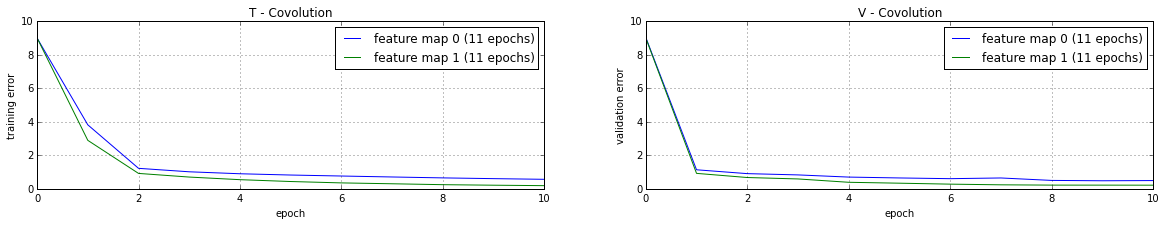

In [5]:
results.draw("feature map", 1, 2, figsize=(20, 3))

#### EXPERIMENT
Explore convolutional networks with two convolutional layers, 
by implementing, training, and evaluating a network with two 
convolutional+maxpooling layers with 5 feature maps in the 
first convolutional layer, and 10 feature maps in the second convolutional layer.

In [31]:
%matplotlib inline

logger = logging.getLogger()
logger.setLevel(logging.INFO)

# some hyper-parameters
learning_rate = 0.5
max_epochs = 10
cost = CECost()

results = Result("Covolution")

# define the model structure
model = MLP(cost=cost)
model.add_layer(ConvSigmoid(1, 5, image_shape=(28, 28), kernel_shape=(5, 5), stride=(1, 1), irange=0.2))
model.add_layer(ConvMaxPool2D(num_feat_maps=5, conv_shape=(24, 24), pool_shape=(2, 2)))
model.add_layer(ConvSigmoid(5, 10, image_shape=(12, 12), kernel_shape=(5, 5), stride=(1, 1), irange=0.2))
model.add_layer(ConvMaxPool2D(num_feat_maps=10, conv_shape=(8, 8), pool_shape=(2, 2)))
model.add_layer(Sigmoid(idim=160, odim=100))
model.add_layer(Softmax(idim=100, odim=10))

lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                         dp_scheduler=None,
                         l1_weight=0.0, 
                         l2_weight=0.0)
train_dp_conv.reset()
valid_dp_conv.reset()
test_dp_conv.reset()

start = time.clock()
logger.info('Training started...')
train_stats, valid_stats = optimiser.train(model, train_dp_conv, valid_dp_conv)
stop = time.clock()

logger.info('Testing the model on test set...')
tst_cost, tst_accuracy = optimiser.validate(model, test_dp_conv)
logger.warning('MNIST test set accuracy is %.2f %% (cost is %.3f) in %.0f seconds' 
               % (tst_accuracy * 100., tst_cost, stop - start))

results.add_results(train_stats, valid_stats, tst_accuracy)

INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.368. Accuracy is 9.98%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.366. Accuracy is 9.61%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 2.157. Accuracy is 19.56%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 1.028. Accuracy is 70.65%
INFO:mlp.optimisers:Epoch 1: Took 383 seconds. Training speed 143 pps. Validation speed 299 pps.


KeyboardInterrupt: 

In [ ]:
results.draw("", 1, 2, figsize=(20, 3))

**This is the end of coursework 2.**

Please remember to save your notebook, and submit your notebook following the instructions at the top.  Please make sure that you have executed all the code cells when you submit the notebook.
